In [1]:
import os 
import csv
import random
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import FunctionalGroups
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks


In [15]:
from src.exp_cleaner import open_all_xps_files, fill_spectral_data, shift_spectrum, generate_mixture_xps
from src.utils import create_uniform_energy_grid, normalize_spectrum_by_area


## Load the data

Read in XPS data and store values in xps_data

In [6]:
data_path = Path("../data/experimental_data")
polymers = os.listdir(data_path) # Use the first 106 polymers
unknown_copolymers = ['poly(ethylene-co-maleic anhydride) (PECMA)', 'poly(styrene-co-maleic anhydride) (PSCMA)' ]

# Remove copolymers with unkown quantities from the polymers list
polymers = [p for p in polymers if p not in unknown_copolymers]

# Load the data
xps_data = open_all_xps_files(data_path=data_path, elements=polymers)



Material ID: poly(ether ether ketone) (PEEK)
Material ID: poly(vinyl methyl ether) (PVME)
Material ID: poly(4-hydroxystyrene) (PHS)
Material ID: poly(ethyl methacrylate) (PEMA)
Material ID: poly(methyl methacrylate) (PMMA)
Material ID: poly(trans-isoprene) (PtI)
Material ID: poly(glycolide) (PG)
Material ID: Ethylcellulose (ECEL)
Material ID: poly(allylamine hydrochloride) (PAAMC)
Material ID: poly(trifluoroethyl acrylate) (PTFEA)
Material ID: poly(lauryl methacrylate) (PLMA)
Material ID: poly(vinyl ethyl ether) (PVEE)
Material ID: Nylon 6,6 (N66)
Material ID: p-Quaterphenyl [poly(phenylene) oligomer]
Material ID: poly(d,l-lactide) (PL)
Material ID: poly(ethylene sulphide) (PETHS)
Material ID: poly(diallyl isophthalate) (PDAiP)
Material ID: poly(vinyl acetate) (PVAc)
Material ID: poly(methacrylamide) (PMAM)
Material ID: poly(propylene glycol) (PPG)
Material ID: poly(chloroprene) (PCP)
Material ID: poly(4-methyl-1-pentene) (PMP)
Material ID: poly(vinylidine chloride) (PVdC)
Material ID:

#   Create Proper labels

labels need to contain functional group counts *and* the carbon counts, as all values are relative to this

In [7]:

# Initialize the dictionary
relative_labels = {}


with open(Path("../data/carbon_counts.json")) as f:
    plain_alkane_carbon_counts = json.load(f)

# Step 1: Populate relative_labels with initial lists (simplified)
# Assuming 'polymers' and 'xps_data' are correctly defined and populated
for polymer_name in polymers:
    # Directly get data and convert to list, assuming keys exist and data has .tolist()
    relative_labels[polymer_name] = xps_data[1][polymer_name].tolist()

# Step 2: Append the alkane counts (simplified)
# Iterate through the created dictionary
# Using list() on keys allows modifying dict values during iteration safely, though iterating items is often preferred style-wise.
# Let's iterate through items as it's cleaner if just modifying values.
for polymer_name, original_label_list in relative_labels.items():
    # Get count, default to 0 if key is missing or value is None
    alkane_count = plain_alkane_carbon_counts.get(polymer_name, 0)
    if alkane_count is None:
        alkane_count_to_append = 0
    else:
        alkane_count_to_append = alkane_count

    # Create updated list by concatenating original list and the count
    updated_label_list = original_label_list + [alkane_count_to_append]

    # Update the dictionary entry with the new list
    relative_labels[polymer_name] = updated_label_list


print("Finished creating relative_labels with appended counts.")
# 'relative_labels' now holds the final result.
# Example check: print(relative_labels.get('poly(propylene) (PP)'))


        

Finished creating relative_labels with appended counts.


In [8]:
print("\nStep 3: Converting labels back to NumPy arrays...")
polymer_names_to_convert = list(relative_labels.keys()) # Get keys to iterate over
for polymer_name in polymer_names_to_convert:
    try:
        # Convert the list value back to a numpy array
        relative_labels[polymer_name] = np.array(relative_labels[polymer_name])
    except Exception as e:
        print(f"Warning: Could not convert label for '{polymer_name}' back to array: {e}")
print("Finished converting labels to NumPy arrays.")


Step 3: Converting labels back to NumPy arrays...
Finished converting labels to NumPy arrays.


# Standardize Spectra

Make sure all spectra same the same dimensions and BE increments - only 'active' regions with peaks are saved in the original spectral data, but we need them to be standard with no gaps.


In [9]:
start_energy = 0  # Define your start energy
end_energy = 700  # Define your end energy
increment = 0.1  # Define your energy increment

# Fill gaps in the spectral data
filled_data = fill_spectral_data(
    cps_data=xps_data[0],  # CPS dictionary
    be_data=xps_data[3],   # BE dictionary
    start_energy=start_energy,
    end_energy=end_energy,
    increment=increment
)


# Extract Core Region and Normalise

Remove valence region then make sure all spectra have same total area

In [13]:
def align_spectrum_to_reference(
    spectrum: np.ndarray,
    energy_resolution: float = 0.1,
    align_region_eV: tuple = (284.9, 286.1),  # Region to search for alignment peak
    reference_peak_eV: float = 285.1,        # Target energy for alignment
    valence_region_indices: int = 400,
    min_peak_prominence: float = 5e-7,       # Prominence threshold for peak finding
    min_peak_height: float = 1e-3,           # Height threshold for peak finding
    fallback_no_shift: bool = True
) -> tuple[np.ndarray, bool]:
    """
    Aligns a spectrum by shifting it so that the most prominent peak in a 
    defined energy window matches the given reference_peak_eV.

    Args:
        spectrum (np.ndarray): Input 1D spectrum intensity array.
        energy_resolution (float): Energy step size (eV per index).
        align_region_eV (tuple): Energy range (eV) in which to search for alignment peak.
        reference_peak_eV (float): Target energy (eV) to align the chosen peak to.
        valence_region_indices (int): Offset for energy index conversion.
        min_peak_prominence (float): Minimum prominence for peak detection.
        min_peak_height (float): Minimum height for peak detection.
        fallback_no_shift (bool): If True, returns original spectrum if no peak found.

    Returns:
        (np.ndarray, bool): Tuple of (aligned_spectrum, shift_applied).
    """
    from scipy.signal import find_peaks

    shift_applied = False

    if not isinstance(spectrum, np.ndarray) or spectrum.ndim != 1:
        raise TypeError("spectrum must be a 1D numpy array.")
    if len(spectrum) == 0:
        raise ValueError("Input spectrum is empty.")

    # --- Compute index range for alignment region ---
    region_min_eV, region_max_eV = align_region_eV
    start_idx = max(0, int(np.ceil(region_min_eV / energy_resolution)) - valence_region_indices)
    end_idx = min(len(spectrum) - 1, int(np.floor(region_max_eV / energy_resolution)) - valence_region_indices)

    if start_idx >= len(spectrum) or start_idx > end_idx:
        if fallback_no_shift:
            return spectrum.copy(), shift_applied
        raise ValueError("Alignment region outside spectrum range.")

    # --- Find peaks in search region ---
    search_region = spectrum[start_idx : end_idx + 1]
    peaks, _ = find_peaks(search_region, prominence=min_peak_prominence, height=min_peak_height)

    if len(peaks) == 0:
        if fallback_no_shift:
            return spectrum.copy(), shift_applied
        raise ValueError("No suitable peaks found for alignment.")

    # --- Choose the peak closest to reference ---
    peaks_idx = peaks + start_idx
    peak_energies = (peaks_idx + valence_region_indices) * energy_resolution
    closest_idx = np.argmin(np.abs(peak_energies - reference_peak_eV))
    chosen_peak_idx = peaks_idx[closest_idx]
    chosen_peak_eV = peak_energies[closest_idx]

    # --- Calculate required shift ---
    target_idx = (reference_peak_eV / energy_resolution) - valence_region_indices
    shift_amount = target_idx - chosen_peak_idx
    shift_amount = int(round(shift_amount))
    shift_applied = True

    print(f"Aligning: peak at {chosen_peak_eV:.2f} eV → {reference_peak_eV:.2f} eV "
          f"(shift {shift_amount:.2f} indices).")

    # --- Apply shift (interpolation recommended) ---
    aligned_spectrum = shift_spectrum(spectrum, shift_amount)

    return aligned_spectrum, shift_applied

In [14]:

valence_range = 40 #range for core electron binding energy peaks eV
valence_region_index= int(valence_range/0.1)


carbon_start = 285.1
carbon_end = 286.5

carbon_start_idx = int(carbon_start/0.1)- valence_region_index
carbon_end_idx = int(carbon_end/0.1)- valence_region_index

print(carbon_start_idx)
print(carbon_end_idx)


reference_carbon_peak = normalize_spectrum_by_area(filled_data['poly(ethylene), high density (HDPE)'][valence_region_index:])

standardised_data = {}
unaligned_data= {}

n_shifted_spectrum = 0 
n_unshifted_spectrum = 0
shifted_polymers = []

for polymer_name, spectrum in filled_data.items():
    core_spectrum = spectrum[valence_region_index:]
    core_spectrum_normalised = normalize_spectrum_by_area(core_spectrum)
    label = relative_labels[polymer_name]
    trial_spectrum_aligned, shift_applied = align_spectrum_to_reference(spectrum= core_spectrum_normalised,
                                                                     reference_peak_eV=285.1)
    
    if int(label[-1])  > 0:   # if polymer contains at least one plain alkane carbon
        n_shifted_spectrum += 1
        core_spectrum_aligned = trial_spectrum_aligned
        if shift_applied == True:
            shifted_polymers.append(polymer_name)

    else:
        n_unshifted_spectrum += 1
        core_spectrum_aligned = core_spectrum_normalised
       
    standardised_data[polymer_name] = core_spectrum_aligned
    unaligned_data[polymer_name] = core_spectrum_normalised

print(n_shifted_spectrum)
print(n_unshifted_spectrum)
print(len(standardised_data))
print(len(shifted_polymers))

print(type(standardised_data))


2451
2465
Aligning: peak at 285.10 eV → 285.10 eV (shift 0.00 indices).
Aligning: peak at 285.20 eV → 285.10 eV (shift -1.00 indices).
Aligning: peak at 285.20 eV → 285.10 eV (shift -1.00 indices).
Aligning: peak at 285.20 eV → 285.10 eV (shift -1.00 indices).
Aligning: peak at 285.00 eV → 285.10 eV (shift 1.00 indices).
Aligning: peak at 285.10 eV → 285.10 eV (shift 0.00 indices).
Aligning: peak at 285.10 eV → 285.10 eV (shift 0.00 indices).
Aligning: peak at 285.10 eV → 285.10 eV (shift 0.00 indices).
Aligning: peak at 285.00 eV → 285.10 eV (shift 1.00 indices).
Aligning: peak at 285.50 eV → 285.10 eV (shift -4.00 indices).
Aligning: peak at 285.90 eV → 285.10 eV (shift -8.00 indices).
Aligning: peak at 285.30 eV → 285.10 eV (shift -2.00 indices).
Aligning: peak at 285.20 eV → 285.10 eV (shift -1.00 indices).
Aligning: peak at 285.00 eV → 285.10 eV (shift 1.00 indices).
Aligning: peak at 285.20 eV → 285.10 eV (shift -1.00 indices).
Aligning: peak at 285.10 eV → 285.10 eV (shift 0.00 

## Generate Synthetic Spectra

Here there are a few variables to set:

* `polymers` - this is the list of the directories that you want to explore. If left balnk the code automatically uses all polymers in the `data_path`
* `data_size` - the number of training examples to create
* `augment_information` - how to augment the data, `max_shift` refers to the maximum amount the data can be shifted up or down in energy, `ranges` the indices from the data to use. Currently just use the defaults provided
* `max_materials_per_sample` - how many polymers to mix for a sprectrum at most. 2 is a good default for now.

In [ ]:
data_size = 100
max_materials_per_sample = 4


labels = []
spectra = []
fra = []

for i in range(data_size):
    spec, lab, frac = generate_mixture_xps(standardised_data, relative_labels, xps_data[2], max_materials_per_sample, debug=False)
    labels.append(lab)
    spectra.append(spec)
    fra.append(frac)

# Save Synthetic Spectra

In [ ]:
synth_spectra_dir = Path('../data/synthetic_data_hard_final/synthetic_spectra2')
synth_labels_dir = Path('../data/synthetic_data_hard_final/synthetic_labels2')

# Create the directories if they don't exist (recommended)
synth_spectra_dir.mkdir(parents=True, exist_ok=True)
synth_labels_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving {data_size} items to .npy format...")

for i in range(data_size):
    # Ensure the data for saving is a NumPy array
    # If spectra[i] or labels[i] might be simple lists, convert them.
    # Use np.asarray() if you don't necessarily need a copy.
    current_spectrum = np.asarray(spectra[i])
    current_label = np.asarray(labels[i])

    # Construct the full file path using pathlib's / operator
    spectra_filepath = synth_spectra_dir / f'spectrum_{i}.npy'
    labels_filepath = synth_labels_dir / f'label_{i}.npy'

    # Save the NumPy arrays directly
    np.save(spectra_filepath, current_spectrum)
    np.save(labels_filepath, current_label)

    # Optional: Add progress indicator for large datasets
    # if (i + 1) % 100 == 0:
    #     print(f"Saved {i + 1}/{data_size} files...")

print("Finished saving .npy files.")



Saving 100000 items to .npy format...
Finished saving .npy files.


# Useful Plots

## 1. Visualize specific input spectra

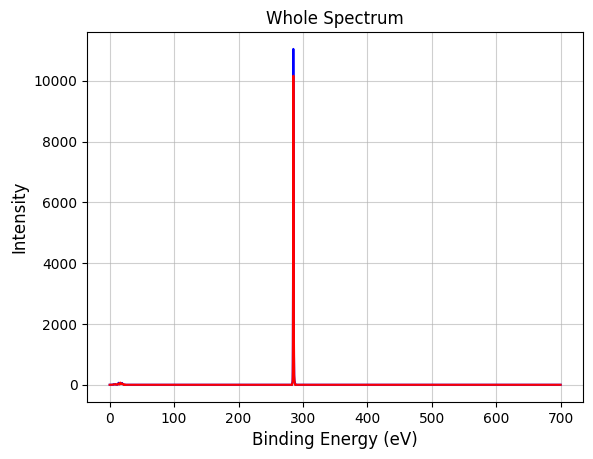

In [ ]:

# setup a list of binding energy values for the entire spectrum range to act as an x-axis

start_energy = 0  # Define your start energy
end_energy = 700.1  # Define your end energy
increment = 0.1  # Define your energy increment
BE_axis_full = np.arange(start_energy,end_energy, increment)



# choose which polymers to plot (use full names (folder names)
PE= 'poly(ethylene), high density (HDPE)'
PP = 'poly(propylene) (PP)'


plt.plot(BE_axis_full, filled_data[PE], color ='blue', label = 'poly(ethylene)')
plt.plot(BE_axis_full, filled_data[PP], color ='red', label = 'poly(propylene)')

plt.grid(True, alpha = 0.6)
plt.title('Whole Spectrum')

# --- Add Overall Figure Elements ---=
plt.xlabel("Binding Energy (eV)", fontsize=12, y=0.02)

# --- !! Adjust Y-axis Super Label Position !! ---
plt.ylabel("Intensity", fontsize=12, x=0.08)

You can make more fancy/useful plots by zooming in on the 'active' regions where there are peaks, using matplotlib's subplot functionality 


/tmp/ipykernel_1264556/1406423142.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect


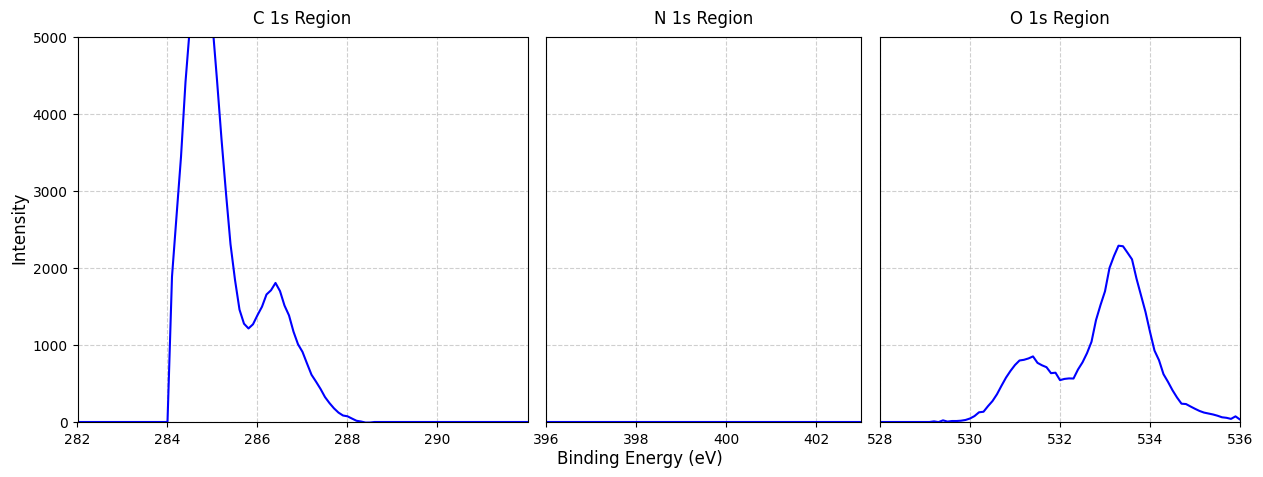

In [24]:
polymer_name = 'poly(ether ether ketone) (PEEK)'
example_spectrum = filled_data[polymer_name] # Assuming filled_data is loaded

# --- Configuration for Zoom Regions ---
# Define ALL potential regions of interest and their titles for PEEK
all_regions = [
    (282, 292),   # Region 1: C 1s region 
    (396, 403),   # Region 2: O 1s region
    (528, 536)      # Region 3: Full Survey (Example)
]


all_region_titles = ["C 1s Region", "N 1s Region", "O 1s Region"]
include_region_1 = True
include_region_2 = True
include_region_3 = True # Set to True if you want the full survey plot as well
include_flags = [include_region_1, include_region_2, include_region_3]

# --- Tick Interval Configuration ---
x_tick_interval = 2.0 # Set desired interval (e.g., ticks every 2 eV) - adjust as needed

# --- Filter regions based on flags ---
active_regions = []
active_region_titles = []
active_widths = []
if len(all_regions) != len(all_region_titles) or len(all_regions) != len(include_flags):
    raise ValueError("Mismatch in length between regions, titles, and flags!")
for i, include in enumerate(include_flags):
    if include:
        region = all_regions[i]
        active_regions.append(region)
        active_region_titles.append(all_region_titles[i])
        active_widths.append(region[1] - region[0])
if not active_regions:
    print("No regions selected for plotting. Exiting.")
    exit() # Or handle appropriately
num_active_regions = len(active_regions)

# --- Plotting Setup (Uses filtered lists) ---
fig = plt.figure(figsize=(5 * num_active_regions, 5)) # Adjust figsize as needed
gs = fig.add_gridspec(1, num_active_regions, width_ratios=active_widths, wspace=0.05)
axes = []
for i in range(num_active_regions):
    share_y_ax = axes[0] if i > 0 else None
    ax = fig.add_subplot(gs[i], sharey=share_y_ax)
    axes.append(ax)

# --- Plotting Data on Each Active Axis ---
for i, ax in enumerate(axes):
    # Plot the simple PEEK spectrum
    ax.plot(BE_axis_full, example_spectrum, color="blue", linewidth=1.5, label=polymer_name if i == 0 else "")

    # Set the x-axis limits for the current ACTIVE region
    ax.set_xlim(*active_regions[i])

    # --- Calculate and Set Consistent Ticks ---
    xmin, xmax = ax.get_xlim()
    # Calculate the first tick >= xmin at the interval step
    start_tick = np.ceil(xmin / x_tick_interval) * x_tick_interval
    # Calculate the last tick <= xmax at the interval step
    end_tick = np.floor(xmax / x_tick_interval) * x_tick_interval

    # Generate ticks, handle cases where range is small or doesn't contain interval steps
    if start_tick > end_tick + 1e-6: # Add small epsilon for float comparison
        calculated_ticks = ax.get_xticks() # Keep default ticks if range is smaller than interval
        print(f"Warning: Region {i+1} ({xmin:.1f}-{xmax:.1f}) is smaller than tick interval {x_tick_interval}. Using default ticks.")
    elif np.isclose(start_tick, end_tick) and xmax-xmin > 0: # Avoid single tick if range has width
         calculated_ticks = np.array([start_tick]) if start_tick >= xmin and start_tick <= xmax else ax.get_xticks() # Use default if single tick outside range
    elif xmax-xmin == 0: # Handle zero width case
        calculated_ticks = [xmin]
    else:
        # Generate ticks within the calculated range
        calculated_ticks = np.arange(start_tick, end_tick + x_tick_interval * 0.1, x_tick_interval)
        # Ensure ticks are within the actual plot limits
        calculated_ticks = calculated_ticks[(calculated_ticks >= xmin) & (calculated_ticks <= xmax)]
    



    # --- Conditionally Remove Last Tick from First Axis if needed ---
   # --- !! Conditionally Remove Last Tick from First Axis !! ---
    if i == 0 and num_active_regions > 1 and len(calculated_ticks) > 1:
        final_ticks = calculated_ticks[:-1] # Remove the last calculated tick for ax1
    else:
        final_ticks = calculated_ticks # Use all calculated ticks for other axes

    ax.set_xticks(final_ticks) # Apply the calculated (and potentially trimmed) ticks

    # --- Apply Grid (Now based on consistent ticks) ---
    ax.grid(True, linestyle='--', alpha=0.6)

    # Set individual region titles
    ax.set_title(active_region_titles[i], pad=10, fontsize=12)

    # Customize y-ticks for non-first plots
    if i > 0:
        ax.tick_params(left=False, labelleft=False)

# --- Add Overall Figure Elements ---=
fig.supxlabel("Binding Energy (eV)", fontsize=12, y=0.02)

# --- !! Adjust Y-axis Super Label Position !! ---
# Decrease the 'x' value to move it left, closer to the axis
fig.supylabel("Intensity", fontsize=12, x=0.08) # Adjust x (e.g., 0.02, 0.01)

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect
plt.grid(True)
plt.ylim(0,5000)


plt.show()